Welcome! This notebook serves as a presentation of the thought processes and the intermediate steps that led to the final animated graph in this project.

# Motivation

The starting point for the exploration was the graph presented by [Hans Rosling](https://en.wikipedia.org/wiki/Hans_Rosling) in his TED talk ["Global population growth, box by box"](https://www.ted.com/talks/hans_rosling_global_population_growth_box_by_box#t-439293).

<img src="./images/rosling.png" alt="Rosling's Graph" style="width: 50%;"/>

<u>Some remarks:</u>
- We are dealing with **4-dimensional** data that tracks three variables (child mortality, fertility and population) over time.
- Rosling is presenting this data on an **animated 2-dimensional graph** which only gives us access to **3 dimensions**. The 4th dimension (population) is shown through the size of the dots representing each country.
- The size of the country dots don't seem to be changing in Rosling's animation. This raises the question which year or aggregate measure he was using for determining the sizes.
- Thinking about it there is actually a 5th dimension: the continent to which each country belongs, which is represented by the color of the dots.

**NB 1**: The graphs presented here will be showing life expectancy and not child mortality as in the original graph.

***Could we instead show the population on a third axis to better visualize how the world's population mass is evolving over time in relation to these variables?***


---
# Loading the data


In [18]:
# Standard Library ---------------------------------------------------------------------
from os import getenv, path

# Third Party --------------------------------------------------------------------------
import matplotlib.pyplot as plt

from dotenv import load_dotenv

# Data Science
import numpy as np
import pandas as pd


load_dotenv()

DATA_DIR = getenv("DATA_DIR")
PROCESSED_DATA_DIR = getenv("PROCESSED_DATA_DIR")

POPULATION_DATA_FILE = getenv("POPULATION_DATA_FILE")
LIFE_EXPECTANCY_DATA_FILE = getenv("LIFE_EXPECTANCY_DATA_FILE")
FERTILITY_DATA_FILE = getenv("FERTILITY_DATA_FILE")

population = pd.read_csv(
    path.join("..", DATA_DIR, PROCESSED_DATA_DIR, POPULATION_DATA_FILE), index_col=0
)
life_expectancy = pd.read_csv(
    path.join("..", DATA_DIR, PROCESSED_DATA_DIR, LIFE_EXPECTANCY_DATA_FILE),
    index_col=0,
)
fertility = pd.read_csv(
    path.join("..", DATA_DIR, PROCESSED_DATA_DIR, FERTILITY_DATA_FILE), index_col=0
)

merged_data = pd.DataFrame(
    {
        "population": population.stack(),
        "life_expectancy": life_expectancy.stack(),
        "fertility": fertility.stack(),
    }
)

---
# First Attempt: Scatter Plot

The most straight forward approach was to simply plot the data in three dimensions, where each country is represented by a dot.

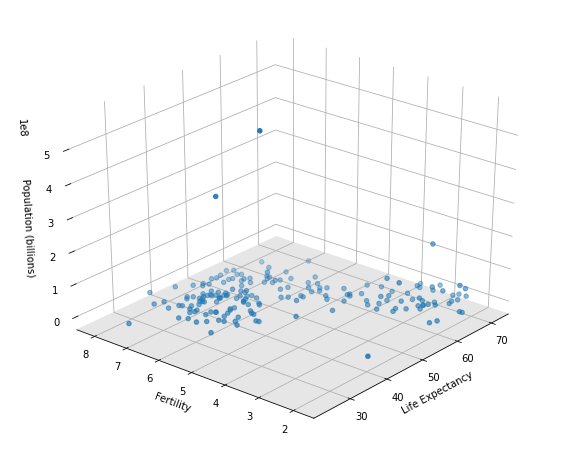

In [19]:
ax = plt.axes(projection="3d")
year_1950 = merged_data.stack().unstack(1)["1950"].unstack(1)
ax.scatter(
    year_1950["life_expectancy"],
    year_1950["fertility"],
    year_1950["population"],
    cmap=plt.cm.viridis,
)

# Visual Adjustments
plt.gcf().set_size_inches(10, 8)

ax.set_xlabel("Life Expectancy")
ax.set_ylabel("Fertility")
ax.set_zlabel("Population (billions)")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(30, 220)

It is possible to animate it, and we end up with something like this:

<img src="../gifs/gapminder_scatter.gif" alt="Gapminder Scatterplot Animation" width="70%" style="margin:0"/>

→ One can more or less follow the tragectory of the dots, but it is hard to see exactly how the population mass evolves, without seeing any volume.

---
# Second Attempt: Naive Surface Plot

The second attempt was to draw the surface formed by all the countries to see the population mass evolve more clearly:

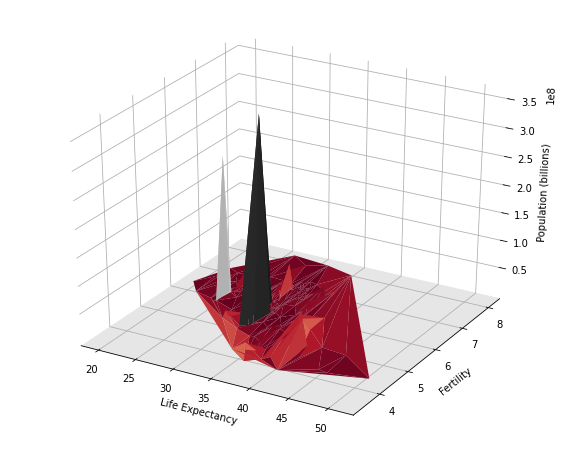

In [20]:
# Plotting
ax = plt.axes(projection="3d")
year_1870 = merged_data.stack().unstack(1)["1870"].unstack(1)
ax.plot_trisurf(
    year_1870["life_expectancy"],
    year_1870["fertility"],
    year_1870["population"],
    cmap="RdGy",
)

# Visual Adjustments
plt.gcf().set_size_inches(10, 8)

ax.set_xlabel("Life Expectancy")
ax.set_ylabel("Fertility")
ax.set_zlabel("Population (billions)")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

And animating it again:

<img src="../gifs/gapminder_trisurf.gif" alt="Gapminder Triangular Surface Plot Animation" width="70%" style="margin:0"/>

→ This somewhat goes into the right direction, although it is a bit jumpy and edgy.

→ Connecting all the dots with triangles can be misleading, as the surface may cover up "valeys" and give a false impression of population mass.

---
# Third Attempt: Grid

The final and most promissing attempt was to create a grid and fill it in with the appropriate population data.

(0.0, 1.0)

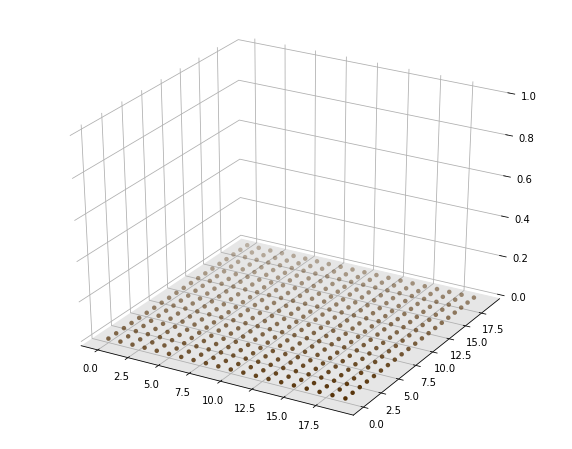

In [21]:
# Plotting
grid_size = 20
ax = plt.axes(projection="3d")
x2, y2 = np.meshgrid(range(0, grid_size), range(0, grid_size))
z2 = np.zeros((grid_size, grid_size))
ax.scatter(x2, y2, z2, c=z2, cmap="BrBG", linewidth=0.01)

# Visual Adjustments
plt.gcf().set_size_inches(10, 8)

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_zlim(0, 1)

Now every square in the grid needs to be raised by the size of the population that is contained in it. For that we start by creating some empty coordinate arrays, that will get filled in with the correct values subsequently.

In [22]:
x1 = np.repeat(np.linspace(0, 100, grid_size), 2)
y1 = np.repeat(np.linspace(0, 10, grid_size), 2)
x2, y2 = np.meshgrid(
    np.repeat(np.linspace(0, 100, grid_size), 2),
    np.repeat(np.linspace(0, 10, grid_size), 2),
)
z2 = np.zeros((grid_size * 2, grid_size * 2))


def add_population(data):
    a1, a2, b1, b2 = (0, 0, 0, 0)

    for x_index, x_value in enumerate(list(x1)):
        if data["life_expectancy"] < x_value:
            a1 = x_index - 1
            a2 = x_index
            break

    for y_index, y_value in enumerate(list(y1)):
        if data["fertility"] < y_value:
            b1 = y_index - 1
            b2 = y_index
            break

    z2[b1][a1] += data["population"]
    z2[b1][a2] += data["population"]
    z2[b2][a1] += data["population"]
    z2[b2][a2] += data["population"]

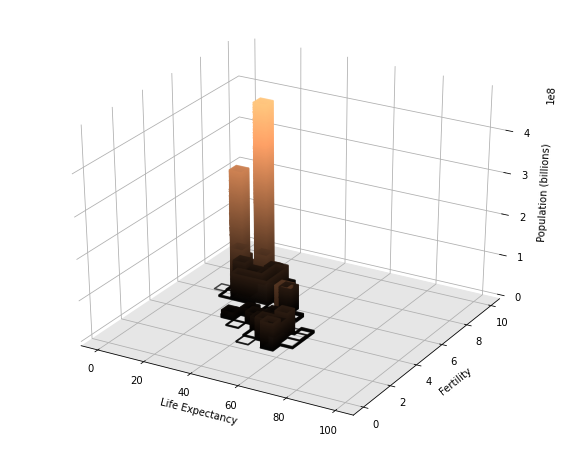

In [23]:
# Plotting
ax = plt.axes(projection="3d")
year_1920 = merged_data.stack().unstack(1)["1920"].unstack(1)
z2 = np.zeros((grid_size * 2, grid_size * 2))
year_1920.apply(add_population, axis=1)
ax.contour3D(x2, y2, z2, 500, cmap="copper", alpha=0.7)

# Visual Adjustments
plt.gcf().set_size_inches(10, 8)

ax.set_xlabel("Life Expectancy")
ax.set_ylabel("Fertility")
ax.set_zlabel("Population (billions)")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

→ This looks bit less smooth but seems to give a more accurate representation of the evolution of population.

Iterating over the years, the final animation gives us the following:

<img src="../gifs/gapminder.gif" alt="Gapminder  Animation" width="70%" style="margin:0"/>